# Text Analysis

---
## Setup

### Importing packages

<div class="alert alert-block alert-info">
<b>Note:</b>
Package SpiCy needs to be lower than 1.13 version, please run:

<p style="background:black">
<code style="background:black;color:white"> pip/conda install spicy==1.12

</code>
</p>



</div>






In [22]:
import os
import nltk
import PyPDF2
import wordcloud
import matplotlib.pyplot as plt
from collections import Counter
from gensim import corpora, models
from collections import defaultdict


### Converting PDF to txt

In [ ]:
# import os
# import PyPDF2

# script_dir = os.getcwd()


# input_folder = os.path.join(script_dir, 'Minutes')
# output_folder = os.path.join(script_dir, 'Text_Files')

# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# 
# file_names = os.listdir(input_folder)

# for file_name in file_names:
#     if file_name.endswith('.pdf'):
#         with open(os.path.join(input_folder, file_name), 'rb') as pdf_file:
#             # Create a PDF reader object
#             pdf_reader = PyPDF2.PdfReader(pdf_file)
            
#             # Extract text from each page
#             text = ''
#             for page_num in range(len(pdf_reader.pages)):
#                 text += pdf_reader.pages[page_num].extract_text()

#         output_file_path = os.path.join(output_folder, os.path.splitext(file_name)[0] + '.txt')
        
#         with open(output_file_path, 'w', encoding='utf-8') as txt_file:
#             txt_file.write(text)

# print("PDF files converted to text and saved in", output_folder)


## ASL & LDS
##### Calculating Average Sentence Length and Lexical Diversity Score 

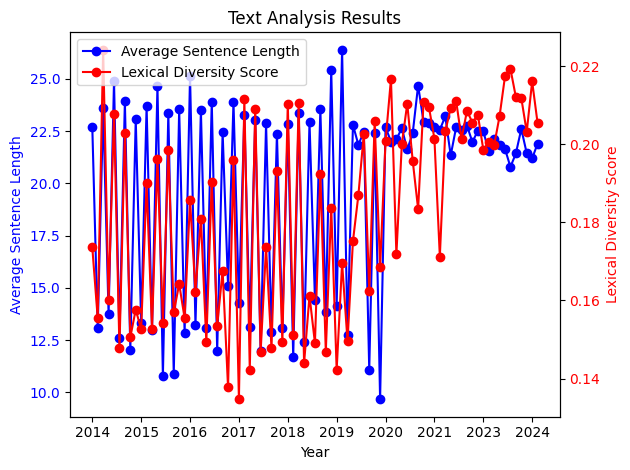

In [2]:
def calculate_average_sentence_length(text):
  sentences = text.split(".")  

  if len(sentences) == 0:
    return 0  

  total_words = sum(len(sentence.split()) for sentence in sentences)
  average_length = total_words / len(sentences)
  return average_length

def calculate_lexical_diversity(text):
  # Lowercase 
  words = [word.lower() for word in text.split() if word.isalpha()]

  # Count words
  word_counts = Counter(words)

  # Total number of words
  num_words = sum(word_counts.values())

  # Vocabulary size
  num_vocab = len(word_counts)

  if num_words == 0:
    return 0

  lexical_diversity = num_vocab / num_words
  return lexical_diversity

filenames = []
average_sentence_lengths = []
lexical_diversity_scores = []

folder_path = "Text_Files"

for filename in os.listdir(folder_path):
  if filename.endswith(".txt"):  
    try:
      with open(os.path.join(folder_path, filename), 'r', encoding="utf-8") as file:
        text = file.read()

      average_sentence_length = calculate_average_sentence_length(text)
      lexical_diversity_score = calculate_lexical_diversity(text)

      filenames.append(filename)
      average_sentence_lengths.append(average_sentence_length)
      lexical_diversity_scores.append(lexical_diversity_score)
    except UnicodeDecodeError:
      # Had multiple encoding issues
      print(f"Error decoding {filename}. Skipping...")

fig, ax1 = plt.subplots()

ax1.plot(filenames, average_sentence_lengths, 'b-o', label='Average Sentence Length')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Sentence Length', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Secondary Y axis
ax2 = ax1.twinx()

ax2.plot(filenames, lexical_diversity_scores, 'r-o', label='Lexical Diversity Score')
ax2.set_ylabel('Lexical Diversity Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Text Analysis Results')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

x_labels = [filename[11:15] for i, filename in enumerate(filenames) if i % 9 == 0]  # Extracting year from filename
plt.xticks(range(0, len(filenames), 9), x_labels, rotation=45)

plt.tight_layout()
plt.savefig('Charts./ASLvsLDS.png')
plt.show()


### Adjusting to ASL >= 20

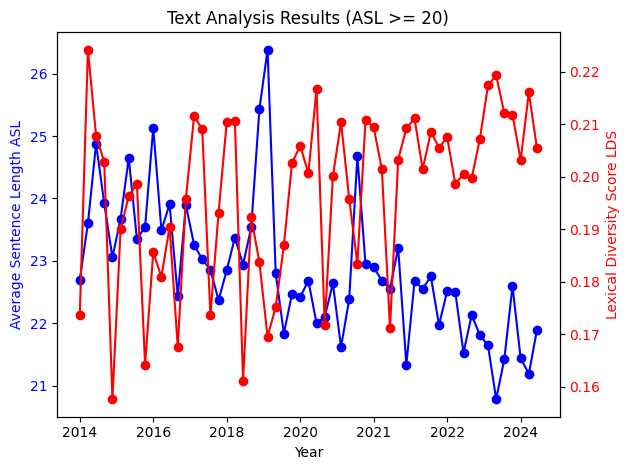

In [4]:
# Filter data based on average sentence length (modify threshold as needed)
filtered_filenames = [filename for filename, asl in zip(filenames, average_sentence_lengths) if asl >= 20]
filtered_average_sentence_lengths = [asl for asl in average_sentence_lengths if asl >= 20]
filtered_lexical_diversity_scores = [lds for lds, asl in zip(lexical_diversity_scores, average_sentence_lengths) if asl >= 20]  # Use zip for corresponding data

# Create the plot
fig, ax1 = plt.subplots()

# Plot average sentence length on the left y-axis
ax1.plot(filtered_filenames, filtered_average_sentence_lengths, 'b-o', label='ASL')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Sentence Length ASL', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Set the secondary y-axis for lexical diversity score
ax2 = ax1.twinx()

# Plot lexical diversity score on the right y-axis
ax2.plot(filtered_filenames, filtered_lexical_diversity_scores, 'r-o', label='LDS')
ax2.set_ylabel('Lexical Diversity Score LDS', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title and legend
plt.title('Text Analysis Results (ASL >= 20)')  # Update title
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#plt.legend(lines1 + lines2, labels1 + labels2, loc='upper left') who needs a legend when you have colors

# Customize x-axis labels
x_labels = [filename[11:15] for i, filename in enumerate(filtered_filenames) if i % 9 == 0]  # Extracting year from filename
plt.xticks(range(0, len(filtered_filenames), 9), x_labels, rotation=45)

plt.tight_layout()  
plt.savefig('Charts/ASLvsLDS20.png')
plt.show()


## Topic Modeling
#### First try with standard number of topics = 5, passess = 15


In [19]:
#nltk.download('stopwords')
#nltk.download('punkt')

# Preprocessing function
def preprocess(text):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = nltk.word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stopwords]

# Function to group words by topics using LDA
def group_by_topic(text, num_topics=5):
    tokens = preprocess(text)
    dictionary = corpora.Dictionary([tokens])
    corpus = [dictionary.doc2bow(tokens)]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    
    topics = lda_model.show_topics(formatted=False)
    grouped_words = defaultdict(list)
    for topic in topics:
        for word, _ in topic[1]:
            grouped_words[topic[0]].append(word)
    
    return grouped_words

directory = 'Text_Files'

all_grouped_words = {}
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
            grouped_words = group_by_topic(text)
            all_grouped_words[filename] = grouped_words

output_filename = 'Datum/'+'topic_output.csv'
with open(output_filename, 'w', encoding='utf-8') as output_file:
    for filename, grouped_words in all_grouped_words.items():
        output_file.write(f"Minutes release: {filename[11:15]}-{filename[15:17]}-{filename[17:19]}\n")
        for topic, words in grouped_words.items():
            output_file.write(f"Topic {topic}: {', '.join(words)}\n")
        output_file.write("\n")

print("See topic_output.csv in Datum")

See topic_output.csv in Datum


#### Increasing N of topics to 20 and doubing passess

In [20]:
# Changed passes and number of topics in hopes that it wouldn't explode my laptop
def group_by_topic(text, num_topics=20):
    tokens = preprocess(text)
    dictionary = corpora.Dictionary([tokens])
    corpus = [dictionary.doc2bow(tokens)]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=30)
    
    topics = lda_model.show_topics(formatted=False)
    grouped_words = defaultdict(list)
    for topic in topics:
        for word, _ in topic[1]:
            grouped_words[topic[0]].append(word)
    
    return grouped_words

directory = 'Text_Files'

all_grouped_words = {}
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r', encoding='utf-8') as file:
            text = file.read()
            grouped_words = group_by_topic(text)
            all_grouped_words[filename] = grouped_words

output_filename = 'Datum./'+'topic_output_increased.csv'
with open(output_filename, 'w', encoding='utf-8') as output_file:
    for filename, grouped_words in all_grouped_words.items():
        output_file.write(f"Minutes release: {filename[11:15]}-{filename[15:17]}-{filename[17:19]}\n")
        for topic, words in grouped_words.items():
            output_file.write(f"Topic {topic}: {', '.join(words)}\n")
        output_file.write("\n")

print("See topic_output_Increased.csv in Datum")

See topic_output_Increased.csv in Datum


## Cloud words

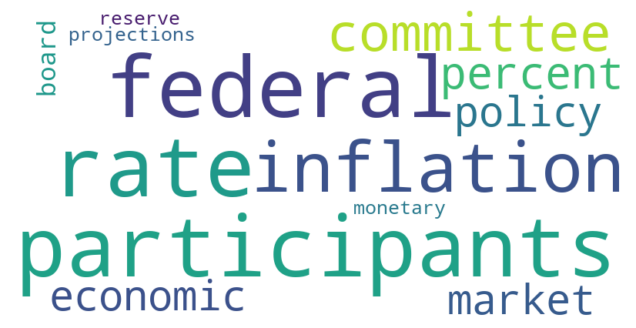

In [23]:
# word cloooud
from wordcloud import WordCloud

# Combining all text files into a single text
combined_text = ''
directory = 'Text_Files'

for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        filepath = os.path.join(directory, filename)
        with open(filepath, 'r', encoding='utf-8') as file: #encoding is always an issue
            combined_text += file.read() + ' '

grouped_words = group_by_topic(combined_text)

all_topic_words = [word for words in grouped_words.values() for word in words]



wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_topic_words))
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('Charts/cloud.png')
plt.show()
